In [74]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


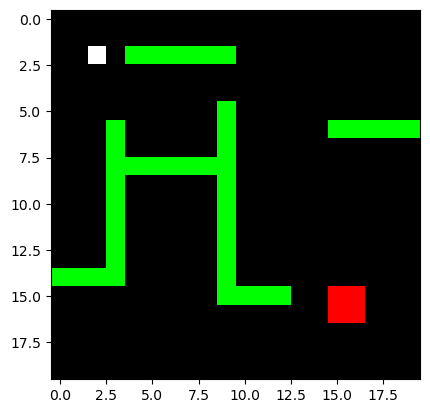

In [75]:
map_matrix = np.load("map_matrix.npy")
plt.imshow(map_matrix)
plt.show()

In [76]:
MAX_Y = map_matrix.shape[0]
MAX_X = map_matrix.shape[1]
noS = MAX_Y * MAX_X
noA = 4

In [77]:
# A, defining action variables
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

# S, a sequence of number rather than coordinates
S = range(noS)

# reward
reward_blank = -0.1  # for every step -1 in other states
reward_wall = -1  # for wall
reward_goal = 0  # for destination
wall = []
goal = []
start = None
for y in range(MAX_Y):
    for x in range(MAX_X):
        if list(map_matrix[y][x]) == [0., 30., 0.]:
            wall.append(y * MAX_X + x)
        elif list(map_matrix[y][x]) == [255., 0., 0.]:
            goal.append(y * MAX_X + x)
        elif list(map_matrix[y][x]) == [255., 255., 255.]:
            start = (y, x)
print("--> State of walls:", wall)
print("--> State of destination:", goal)

# P[s][a] = (state transition probability, next state, reward, done)
P = dict()
grid = np.arange(noS).reshape(map_matrix.shape[0:2])
it = np.nditer(grid, flags=['multi_index'])

while not it.finished:
    s = it.iterindex
    y, x = it.multi_index
    P[s] = dict()
    #if (terminal_state(s)):
    if (s in goal):  # s in terminal_state:
        P[s][UP] = (1.0, s, reward_goal, True)
        P[s][RIGHT] = (1.0, s, reward_goal, True)
        P[s][DOWN] = (1.0, s, reward_goal, True)
        P[s][LEFT] = (1.0, s, reward_goal, True)
    else:
        ns_up = s if y == 0 else s - MAX_X
        ns_right = s if x == (MAX_X - 1) else s + 1
        ns_down = s if y == (MAX_Y - 1) else s + MAX_X
        ns_left = s if x == 0 else s - 1

        if s in goal:
            rw = reward_goal
        elif s in wall:
            rw = reward_wall
        else:
            rw = reward_blank

        P[s][UP] = (1.0, ns_up, rw, ns_up in goal)
        P[s][RIGHT] = (1.0, ns_right, rw, ns_right in goal)
        P[s][DOWN] = (1.0, ns_down, rw, ns_down in goal)
        P[s][LEFT] = (1.0, ns_left, rw, ns_left in goal)
    it.iternext()

print('--> Number of states in grid: ' + str(noS))
print('--> Number of action options in each state:' + str(noA))
print("--> Transition probabilities matrix(prob, next_state, reward, is_done):")
print(P[0])

--> State of walls: [44, 45, 46, 47, 48, 49, 109, 123, 129, 135, 136, 137, 138, 139, 143, 149, 163, 164, 165, 166, 167, 168, 169, 183, 189, 203, 209, 223, 229, 243, 249, 263, 269, 280, 281, 282, 283, 289, 309, 310, 311, 312]
--> State of destination: [315, 316, 335, 336]
--> Number of states in grid: 400
--> Number of action options in each state:4
--> Transition probabilities matrix(prob, next_state, reward, is_done):
{0: (1.0, 0, -0.1, False), 1: (1.0, 1, -0.1, False), 2: (1.0, 20, -0.1, False), 3: (1.0, 0, -0.1, False)}


+ Value Iteration

In [78]:
def value_iteration(P,theta=0.0001, discount_factor=1.0):
    """
    Value iteration

    :param theta: threshold to stop iteration
    :param discount_factor: the same as discount factor in formula
    :return: a policy and a state-value matrix V
    """


    V = np.zeros(noS)
    step = np.inf
    while step >= theta:
        # TODO: finish value iteration
        step = 0.0
        for s in S:
            v = V[s]
            V[s] = np.max([P[s][a][2] + V[P[s][a][1]]*discount_factor for a in range(noA)])
            step = max(step, abs(v - V[s]))

    # TODO: find the best policy according to V
    # Create a deterministic policy using the optimal value function
    # policy[s, a] means the probability of taking action a under state s, in this case, they are one-hot
    policy = np.zeros([noS, noA])
    for s in S:
        decision = np.argmax([P[s][a][2] + V[P[s][a][1]]*discount_factor for a in range(noA)])
        policy[s][decision] = 1

    return policy, V

In [79]:
iteration = value_iteration
policy, v = iteration(P)

In [80]:
# display modules
def display_policy(policy_map: np.ndarray, des=((15, 16), (15, 15), (16, 15), (16, 16))):
    """
    Display policy in a vector field
    :param des: destination, for dying quiver
    :param policy_map: your policy map where each position is a number standing for an action
    :return:
    """

    def phrase_action(action: int):
        if action == 0:
            return 0, 1
        if action == 1:
            return 1, 0
        if action == 2:
            return 0, -1
        if action == 3:
            return -1, 0
        return 0, 0

    des = np.asarray(np.copy(des))

    X, Y = policy_map.shape
    grid_X = np.arange(X).reshape(-1, 1).repeat(Y, axis=1)
    grid_Y = np.arange(Y).reshape(1, -1).repeat(X, axis=0)
    direct_X, direct_Y = [], []
    C = []
    for x_row in list(zip(grid_X, grid_Y)):
        for p in tuple(zip(x_row[0], x_row[1])):
            direct_x, direct_y = phrase_action(policy_map[p[0], p[1]])
            direct_X.append(direct_x)
            direct_Y.append(direct_y)
            if des is not None:
                C.append(np.sum(np.abs(p - des)))
    fig = plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.xaxis.set_ticks_position('top')  # 将X坐标轴移到上面
    ax.invert_yaxis()  # 反转Y坐标轴
    plt.quiver(grid_X, grid_Y, direct_X, direct_Y, 0 if len(C) == 0 else C)
    plt.show()


def display_v(V: np.ndarray, map_m: np.ndarray):
    """
    display state value in heat map
    :param map_m: 2D map matrix corresponding to v
    :param V: state value, 1D
    :return:
    """

    heatmap = V.reshape(map_m.shape[0:2])
    plt.imshow(heatmap, cmap=plt.cm.autumn)
    plt.colorbar()
    plt.show()


def display_path(policy_map, map_m, departure, des, max_iter=100):
    """

    :param policy_map: policy
    :param map_m: map
    :param departure: start point
    :param des: destination
    :return:
    """
    map_m = np.copy(map_m)

    now_y, now_x = departure
    iter_n = 0
    while now_y * MAX_X + now_x not in des:
        if iter_n > max_iter:
            break
        map_matrix[now_y, now_x, :] = np.array([151, 255, 255])
        if UP == policy_map[now_y, now_x]:
            now_y = now_y - 1
        elif RIGHT == policy_map[now_y, now_x]:
            now_x = now_x + 1
        elif DOWN == policy_map[now_y, now_x]:
            now_y = now_y + 1
        elif LEFT == policy_map[now_y, now_x]:
            now_x = now_x - 1
        now_y = (now_y + MAX_Y) % MAX_Y
        now_x = (now_x + MAX_X) % MAX_X
        map_m[now_y, now_x, :] = 120
        plt.imshow(map_m)
        plt.show()
        clear_output(wait=True)

        iter_n += 1

Grid Policy (0=up, 1=right, 2=down, 3=left):


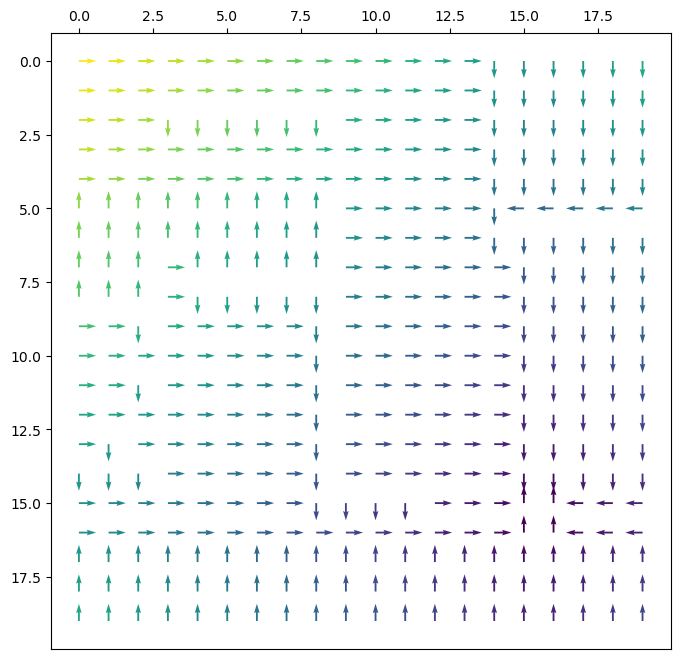

In [81]:
print("Grid Policy (0=up, 1=right, 2=down, 3=left):")
grid_policy = np.reshape(np.argmax(policy, axis=1), map_matrix.shape[0:2])
display_policy(grid_policy.T)

State value:


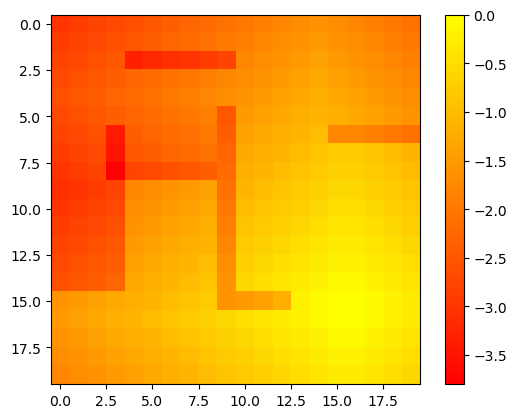

In [82]:
print("State value:")
display_v(v, map_matrix)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


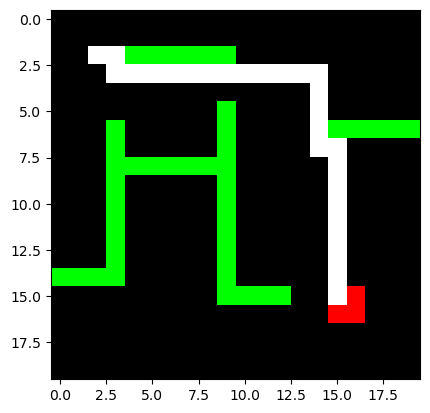

In [83]:
%matplotlib inline
display_path(grid_policy, map_matrix, start, goal)

1. What are the strengths of MDP; when does it perform well?

    - It suits many complex decision scenarios.
    - When the future statuses of the system is certain and probabilistically predictable, it performs well.

2. What are the weaknesses of MDP; when does it perform poorly?

    - The assumed probabilities are constants.
    - The probabilities need to be specified before all.
    - Complex and costly computations are involved.
    - It performs poorly when the space is large, which slows everything down, or when the probabilities are not constants or not well chosen.

3. What makes MDP a good candidate for the clustering problem, if you have enough knowledge about the data?

    - When the model needs to analyze probabilities and state changes in complex systems, MDP will be a good candidate.